<a href="https://colab.research.google.com/github/AMerrington/sense-hackathon/blob/leopauly/SENSE_CDT_Practical_Session_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Sentinel-1 Ice, Water, Land Segmentation Challenge

Version : leopauly

In [26]:
## Imports
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
## Mounting drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [3]:
## Setting variables
SAMPLING_DIR ='/content/drive/MyDrive/png_samples_200x200/'
META_DIR ='/content/drive/MyDrive/tiff_sample_metadata/meta3.npy'
TRAIN_SIZE = 0.7
VALID_SIZE = 1.0 - TRAIN_SIZE
LABELS = {"L": 0,"W": 1,"I": 2,}

In [4]:
## Checking loaded dataset

print('Dataset tile patches:')
print(os.listdir(SAMPLING_DIR))
print('\nMetafile details:')
meta=np.load(META_DIR)
print('Meta file size:',np.shape(meta))
print('patch ID:',[row[0] for row in meta])
print('x_cord:',[row[1] for row in meta])
print('y_cord:',[row[2] for row in meta])
print('labels:',[LABELS[row[3]] for row in meta])

Dataset tile patches:
['9126.png', '8454.png', '9540.png', '9192.png', '8305.png', '8586.png', '8744.png', '7998.png', '8603.png', '8102.png', '9961.png', '9676.png', '9357.png', '8810.png', '8018.png', '9204.png', '9155.png', '9515.png', '8469.png', '8781.png', '9195.png', '8540.png', '7632.png', '9095.png', '8110.png', '7770.png', '7565.png', '8423.png', '8386.png', '7942.png', '8024.png', '9427.png', '9642.png', '9472.png', '8661.png', '8969.png', '7996.png', '8588.png', '9131.png', '9500.png', '7701.png', '9946.png', '9902.png', '8415.png', '8355.png', '9479.png', '7969.png', '7728.png', '7958.png', '10025.png', '9098.png', '7972.png', '9911.png', '9731.png', '9995.png', '7781.png', '9426.png', '8132.png', '8706.png', '8409.png', '9785.png', '8800.png', '9979.png', '8161.png', '9191.png', '8700.png', '9813.png', '9761.png', '7906.png', '9966.png', '9636.png', '8893.png', '8190.png', '9581.png', '7664.png', '9549.png', '9455.png', '8335.png', '8509.png', '8997.png', '8047.png', '954

In [33]:
## Loading data 
x_list=[row[0] for row in meta]
print('image IDs in x:',x_list)

y=[LABELS[row[3]] for row in meta]
print('labels in y:',y)

print(np.shape(x_list),np.shape(y))

x=[]
for index in range(100):
  x.append(Image.open(SAMPLING_DIR + str(x_list[index]) + ".png"))

image IDs in x: ['7520', '7521', '7522', '7523', '7524', '7525', '7526', '7527', '7528', '7529', '7530', '7531', '7532', '7533', '7534', '7535', '7536', '7537', '7538', '7539', '7540', '7541', '7542', '7543', '7544', '7545', '7546', '7547', '7548', '7549', '7550', '7551', '7552', '7553', '7554', '7555', '7556', '7557', '7558', '7559', '7560', '7561', '7562', '7563', '7564', '7565', '7566', '7567', '7568', '7569', '7570', '7571', '7572', '7573', '7574', '7575', '7576', '7577', '7578', '7579', '7580', '7581', '7582', '7583', '7584', '7585', '7586', '7587', '7588', '7589', '7590', '7591', '7592', '7593', '7594', '7595', '7596', '7597', '7598', '7599', '7600', '7601', '7602', '7603', '7604', '7605', '7606', '7607', '7608', '7609', '7610', '7611', '7612', '7613', '7614', '7615', '7616', '7617', '7618', '7619', '7620', '7621', '7622', '7623', '7624', '7625', '7626', '7627', '7628', '7629', '7630', '7631', '7632', '7633', '7634', '7635', '7636', '7637', '7638', '7639', '7640', '7641', '7642',

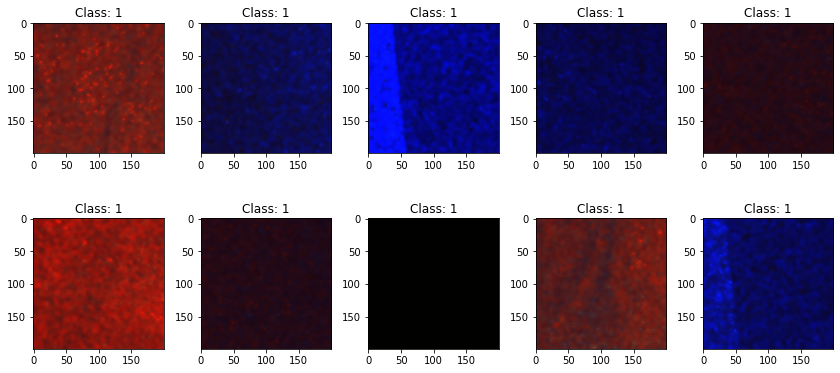

In [40]:
## Data visualisation 
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(10):

    axs[i].imshow(x[i])
    axs[i].set_title('Class: {}'.format(y[i]))

In [24]:
## Creating model

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()

#add model layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(200,200,3)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

Text(0.5, 1.0, '1')

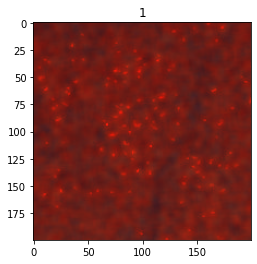

In [6]:
## Database class
class PolarPatch(Dataset):
    def __init__(self, transform=None, split="train"):
        super(PolarPatch, self).__init__()

        assert split in ["train", "val"]
        
        meta = np.load('/content/drive/MyDrive/tiff_sample_metadata/meta3.npy')

        train_dim = int(TRAIN_SIZE * len(meta))
        
        if split == "train":
            meta = meta[:train_dim]
        else:
            meta = meta[train_dim:]                   

        self.images = [row[0] for row in meta] #range(len(meta))
        self.coords = [(row[1], row[2]) for row in meta]

        # Targets in integer form for computing cross entropy
        self.targets = [LABELS[row[3]] for row in meta]
        self.transform = transform


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):

        x = Image.open(SAMPLING_DIR + str(self.images[index]) + ".png")  # ".png") # change this file format if needed
        y = self.targets[index]
        coord = self.coords[index]

        if self.transform:
        	x = self.transform(x)

        return x, y, coord

In [7]:
## Data pre-processing (todo: normalisation)
data_transform = transforms.Compose([transforms.ToTensor()])

In [8]:
## Dataloaders
BATCH_SIZE = 2513 #todo: set this

train_set = PolarPatch(split='train',transform=data_transform)
#test_set = PolarPatch(split='test',transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

In [9]:
## Model
class PolarNet(nn.Module):
    def __init__(self, n_classes=3):
        super(PolarNet, self).__init__()

        self.features = nn.Sequential(
            # TODO: build your own architecture here; one conv layer and ReLU here as an example only
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
        )

        self.classifier = nn.Sequential(
            # TODO: continue classifier section of architecture here for classification approach;
            # otherwise, remove and add in upscaling for a fully-convolutional segmentation approach 
            nn.Linear(4096, n_classes),
        )      

    def forward(self, x):
        # as an example; alter as needed depending on your architecture
        x = self.features(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
## Training
# Device configuration - defaults to CPU unless GPU is available on device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = PolarNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent - TODO: alter as needed
optimizer = optim.SGD(model.parameters(),lr=0.001,weight_decay=0.0005,momentum=0.9)

In [11]:
nb_epoch=2
for epoch in range(nb_epoch): 
    
    running_loss = 0.0
    
    for data in train_loader:

        ## Reading data
        inputs, labels,_ = data
        print(inputs.shape)
        print(labels.shape)

        ## Forward pass+backward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('Finished Training')

torch.Size([1759, 3, 200, 200])
torch.Size([1759])


RuntimeError: ignored

In [ ]:
## Evaluation
